In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Market():
    """
    Represents a binomial market model (CRR).
    """
    def __init__(self, starting_price, u, d, r, T):
        """
        Parameters:
        starting_price (float): Initial price of the asset.
        u (float): Up factor.
        d (float): Down factor.
        r (float): Risk-free interest rate.
        T (int): Time steps.
        """
        self.starting_price = starting_price
        self.u = u
        self.d = d
        self.r = r
        self.T = T
        self.prob = (1 + r - d) / (u - d)  # Risk-neutral probability


    def calculate_price(self, instrument, time=0, path=None):
        if path is None:
            path = [self.starting_price]  

        current_price = path[-1]  

        # (t+1) price 
        up_price = current_price * self.u
        down_price = current_price * self.d

        # Base case
        if time == self.T:
            return instrument(path)

        # Recursive case
        up_value = self.calculate_price(instrument, time + 1, path + [up_price])
        down_value = self.calculate_price(instrument, time + 1, path + [down_price])

        expected_value = self.prob * up_value + (1 - self.prob) * down_value
        discounted_value = expected_value / (1 + self.r)

        return discounted_value
    
    def calculate_price_mc(self, instrument, M):
        """
        Monte Carlo evaluation of the instrument.

        Parameters:
        instrument (callable): The instrument to evaluate.
        M (int): Number of Monte Carlo simulations.

        Returns:
        float: The average price of the instrument.
        """

        values = np.zeros(M)
        for i in range(M):
            path = [self.starting_price]
            for _ in range(self.T):
                if np.random.rand() < self.prob:
                    path.append(path[-1] * self.u)
                else:
                    path.append(path[-1] * self.d)
            values[i] = instrument(path)
        
        return np.cumsum(values) / (np.arange(1, M + 1) * (1 + self.r) ** self.T)
    
    def calculate_price_mc_numpy(self, instrument, M):
        """
        Monte Carlo evaluation of the instrument using numpy array.

        Parameters:
        instrument (callable): The instrument to evaluate.
        M (int): Number of Monte Carlo simulations.

        Returns:
        float: The average price of the instrument.
        """

        values = np.zeros(M)
        for i in range(M):
            path = np.zeros(self.T + 1)
            path[0] = self.starting_price
            for j in range(self.T):
                if np.random.rand() < self.prob:
                    path[j + 1] = path[j] * self.u
                else:
                    path[j + 1] = path[j] * self.d
            values[i] = instrument(path)
        
        return np.cumsum(values) / (np.arange(1, M + 1) * (1 + self.r) ** self.T)

## Eksperymenty

In [3]:
market = Market(starting_price=100, u=1.3, d=0.8, r=0.1, T=10)

def max_payoff(path):
    return max(path)  

In [4]:
N = 10_000
exact_price = market.calculate_price(max_payoff)
estimated_price = market.calculate_price_mc(max_payoff, M=N)
print(f"Exact price: {exact_price:.2f}")
print(f"Estimated price: {estimated_price[-1]:.2f}")

Exact price: 116.88
Estimated price: 116.17


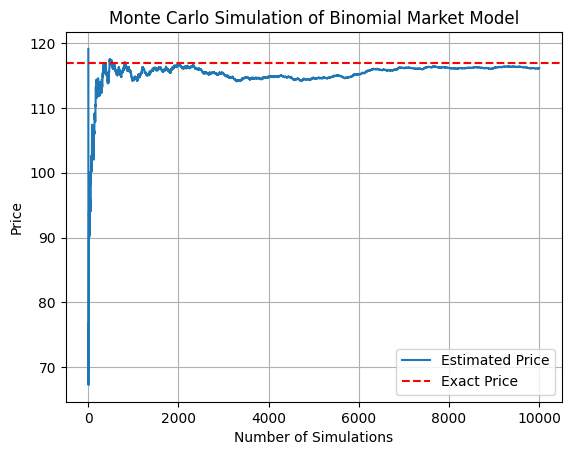

In [5]:
plt.plot(np.arange(1, N + 1), estimated_price, label='Estimated Price')
plt.axhline(y=exact_price, color='r', linestyle='--', label='Exact Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')
plt.title('Monte Carlo Simulation of Binomial Market Model')
plt.legend()
plt.grid()
plt.show()

Widzimy, że cena wyliczona z metody Monte Carlo zbiega do ceny dokładnej wraz z wzrostem liczby symulacji.

### Porównanie zbieżności dla dużych i małych T

In [6]:
small_T = 10
big_T = 25

small_market = Market(starting_price=100, u=1.3, d=0.8, r=0.1, T=small_T)
big_market = Market(starting_price=100, u=1.3, d=0.8, r=0.1, T=big_T)

small_estimated_price = small_market.calculate_price_mc(max_payoff, M=10000)
small_exact_price = small_market.calculate_price(max_payoff)
big_estimated_price = big_market.calculate_price_mc(max_payoff, M=10000)
big_exact_price = big_market.calculate_price(max_payoff)

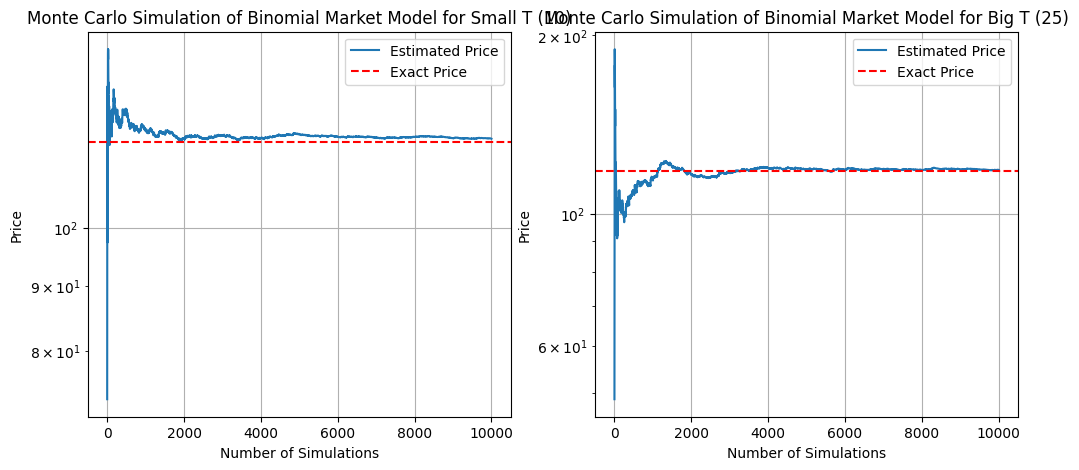

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for small T
axs[0].plot(np.arange(1, 10001), small_estimated_price, label='Estimated Price')
axs[0].axhline(y=small_exact_price, color='r', linestyle='--', label='Exact Price')
axs[0].set_xlabel('Number of Simulations')
axs[0].set_ylabel('Price')
axs[0].set_title('Monte Carlo Simulation of Binomial Market Model for Small T (10)')
axs[0].legend()
axs[0].grid(True)
axs[0].set_yscale('log')

# Plot for big T
axs[1].plot(np.arange(1, 10001), big_estimated_price, label='Estimated Price')
axs[1].axhline(y=big_exact_price, color='r', linestyle='--', label='Exact Price')
axs[1].set_xlabel('Number of Simulations')
axs[1].set_ylabel('Price')
axs[1].set_title('Monte Carlo Simulation of Binomial Market Model for Big T (25)')
axs[1].legend()
axs[1].grid(True)
axs[1].set_yscale('log')

plt.show()

In [8]:
T = 100
huge_market = Market(starting_price=100, u=1.3, d=0.8, r=0.1, T=T)

In [9]:
estimated_price = huge_market.calculate_price_mc(max_payoff, M=100000)

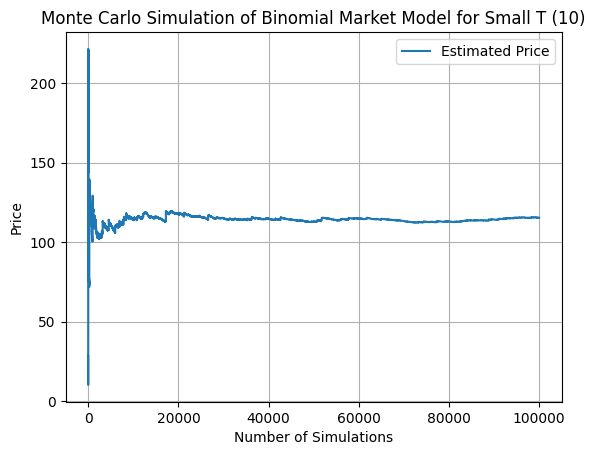

In [10]:
plt.plot(np.arange(1, 100001), estimated_price, label='Estimated Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Price')
plt.title('Monte Carlo Simulation of Binomial Market Model for Small T (10)')
plt.legend()
plt.grid()
plt.show()

In [48]:
huge_market.calculate_price(max_payoff)

KeyboardInterrupt: 

## Porównanie z wersją wykorzystującą numpy

In [15]:
import timeit
print(f"Time taken for numpy implementation: {timeit.timeit("huge_market.calculate_price_mc_numpy(max_payoff, M=10000)", globals=globals(), number=10):.2f} seconds")

Time taken for numpy implementation: 13.94 seconds


In [16]:
print(f"Time taken for non-numpy implementation: {timeit.timeit("huge_market.calculate_price_mc(max_payoff, M=10000)", globals=globals(), number=10):.2f} seconds")

Time taken for non-numpy implementation: 9.22 seconds


## Cython 

In [23]:
from market import Market as CythonMarket

cython_huge_market = CythonMarket(starting_price=100, u=1.3, d=0.8, r=0.1, T=T)

print(f"Time taken for non-numpy implementation in Cython: {timeit.timeit("cython_huge_market.calculate_price_mc(max_payoff, M=10000)", globals=globals(), number=10):.2f} seconds")

print(f"Time taken for numpy implementation in Cython: {timeit.timeit("cthon_huge_market.calculate_price_mc_numpy(max_payoff, M=10000)", globals=globals(), number=10):.2f} seconds")


Time taken for non-numpy implementation in Cython: 9.44 seconds
Time taken for numpy implementation in Cython: 14.24 seconds
